In [47]:
from Model import Model
from Simulation import simulate
from Optimization import FreqDevOptimizer, VoltLossOptimizer
from Math import latin_hypercube_sample
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import networkx as nx
from scipy.optimize import root

RANDOM_SEED = 214075893

# Robustness of Droop-Controlled Inverter Networks

## Preparing the Test Case
We will load the IEEE-RTS 24-bus test case from the MATPOWER repository. 
The `Model.from_test_case()` function reads the nominal bus and branch data from the test case file
on GitHub, in order to parameterize the model.
We have run OPF for test case in MATPOWER already and saved the voltage angles from the optimal solution 
in `/data/case24_opf_angles.csv`. These angles will serve as our initial condition, $\theta_0$.

In [13]:
model = Model.from_test_case('case24_ieee_rts', 10 * np.ones(24,))
theta0 = np.loadtxt('./data/case24_opf_angles.csv', delimiter=',') 

model.p_nom, _ = model.bus_status(theta0)

In the last line, we override the nominal power injections in the file with the "optimal" power injections
computed during OPF. This ensures that the initial condition $\theta_0$ is actually a synchronous 
state of the system. We can verify this by evaluating the nodal frequencies at $\theta_0$, using the `Model.bus_stats()` method:

In [14]:
_, freqs = model.bus_status(theta0)
print('Nodal frequencies (Hz):', freqs)

model.w_nom = freqs[0]

Nodal frequencies (Hz): [60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.
 60. 60. 60. 60. 60. 60.]


For reference, we reproduce the system diagram below:

<img src="misc/ieee24.png" alt="IEEE-RTS 24-bus System" style="width: 300px;"/>

## Evaluating Post-Fault Transient Stability

In [15]:
n_test_pts = 200 
gamma_star = np.pi / 2 - np.maximum(np.abs(model.phiij), np.abs(model.phiji))
np.random.seed(RANDOM_SEED)
Gamma = latin_hypercube_sample(n_test_pts, np.zeros(model.m,), gamma_star)  

In [16]:
u = np.zeros(11,)
opt = FreqDevOptimizer(model)
opt_ignore = FreqDevOptimizer(model, ignore_outward=True)
V_outward = np.array([opt(Gamma[:, i]) for i in range(Gamma.shape[1])])
V_winding = np.array([opt_ignore(Gamma[:, i], u) for i in range(Gamma.shape[1])])
V_both = np.array([opt(Gamma[:, i], u) for i in range(Gamma.shape[1])])

In [17]:
gamma_scale = np.linspace(0.01, np.pi / 4, n_test_pts)

U_outward = np.zeros(n_test_pts,)
U_winding = np.zeros(n_test_pts,)
U_both = np.zeros(n_test_pts,) 

for j in range(n_test_pts):
    larger_gamma_idx = np.all(Gamma >= gamma_scale[j], axis=0)
    if sum(larger_gamma_idx) == 0:
        continue
    U_outward[j] = np.max(V_outward[larger_gamma_idx])
    U_winding[j] = np.max(V_winding[larger_gamma_idx])
    U_both[j] = np.max(V_both[larger_gamma_idx]) 

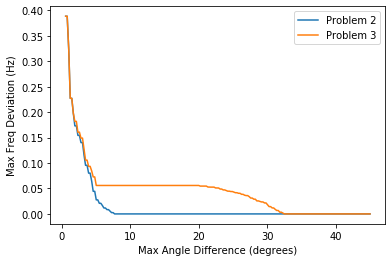

In [77]:
plt.plot(gamma_scale * 180 / np.pi, U_outward)
# plt.plot(gamma_scale * 180 / np.pi, U_winding)
plt.plot(gamma_scale * 180 / np.pi, U_both)
plt.xlabel('Max Angle Difference (degrees)')
plt.ylabel('Max Freq Deviation (Hz)')
plt.legend(['Problem 2', 'Problem 3'])
plt.show()

In [32]:
_, gamma0, _ = model.state_status(theta0)
gamma_larger = np.all(Gamma >= np.c_[gamma0], axis=0)
best_idx = np.argmax(V_winding[gamma_larger])
best_gamma = (Gamma[:, gamma_larger])[:, best_idx]
best_freq_dev = V_winding[gamma_larger][best_idx]

print('Best min-max freq dev:', best_freq_dev)
print('Best gamma (degrees):')
print('\tMin:', np.min(best_gamma) * 180 / np.pi)
print('\tMedian:', np.median(best_gamma) * 180 / np.pi)
print('\tMax:', np.max(best_gamma) * 180 / np.pi)

Best min-max freq dev: 0.04348156642949624
Best gamma (degrees):
	Min: 18.495822911847032
	Median: 20.32892082594466
	Max: 22.10491811452774


## Perturbations of Nominal Injections

Max. pnom perturbations (% of nominal):
[  27.18984267   24.87565996   11.72416831   30.74684237   30.85580837
   17.56261775   25.99951613   13.83558447   11.87392319   10.34188976
  113.25551599 1515.09017305   70.6675497    10.93360224   12.70210431
   31.527968     33.90756367   21.38923252   12.66277439   36.26430623
    5.39140717    7.25665951    3.73315403   87.73896895]
Median: 23.13244623717889


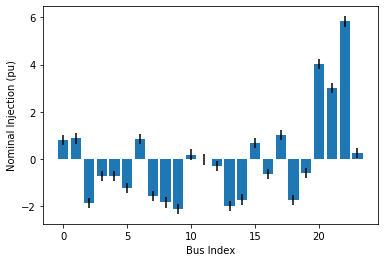

In [45]:
pnom_perturb = 0.5 * model.d * best_freq_dev
rel_pnom_perturb = np.abs(100 * pnom_perturb / model.p_nom)
print('Max. pnom perturbations (% of nominal):')
print(rel_pnom_perturb)
print('Median:', np.median(rel_pnom_perturb))

plt.bar(range(0,24), model.p_nom, yerr=pnom_perturb)
plt.xlabel('Bus Index')
plt.ylabel('Nominal Injection (pu)')
plt.show()

## Perturbations of Voltage Magnitudes

Median: 0.010537025070872457


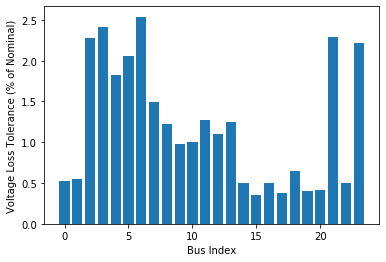

In [52]:
vopt = VoltLossOptimizer(model, theta0)
safe_rel_loss = np.zeros(model.n,)
for i in range(model.n):
    safe_rel_loss[i], _, _ = vopt(best_gamma, i, best_freq_dev)
    
print('Median:', np.median(safe_rel_loss))

plt.bar(range(0,24), 100 * safe_rel_loss)
plt.xlabel('Bus Index')
plt.ylabel('Voltage Loss Tolerance (% of Nominal)')
plt.show()